In [137]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import loadtxt
import os, glob
import geopandas as gpd
import geojsonio
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import math
from IPython.display import Image

import plotly
import plotly.express as px
import chart_studio.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)
cf.go_offline()
%matplotlib inline
#pd.options.plotting.backend = "plotly"

In [138]:
# Dashboard
target="price"
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 100)
pd.options.display.max_seq_items = 300
pd.set_option('display.max_colwidth', 150)
sns.set(style="white")

In [139]:
# Import data_clean
data = pd.read_pickle("saves/data_clean.pkl")

In [140]:
# Alternative: Import from csv
#data_types_clean = pd.read_csv('saves/types_clean.csv')['types']
#data = pd.read_csv("saves/data_clean.csv", dtype=data_types_clean.to_dict())
#data.set_index('id', inplace=True)

# Data Exploration

In [141]:
# Separate/create variables for numerical and categorical features
num_features = list(data.columns[data.dtypes!=object])
cat_features = list(data.columns[data.dtypes==object])
#data_cont = data[num_features]

## Interactive Dashboards

In [142]:
# Display figures from graphical exploration below direcly here in the dashboard
@interact_manual
def show_images(file=os.listdir('data/figures/')):
    display(Image("data/figures/"+file))

interactive(children=(Dropdown(description='file', options=('3_fig1_heatmap.png', 'fig1_heatmap.png', 'fig3_ma…

In [143]:
# Display table with all rows where feature value is > x (where x is the selected threshold)
@interact(x=widgets.IntSlider(1,0,100,1,continuous_update=False))
def filter_data(column=num_features, x=10):
    return data.loc[data[column]>x]

interactive(children=(Dropdown(description='column', options=('accommodates', 'am_balcony', 'am_breakfast', 'a…

In [144]:
# Display interactive plot for comparing two features
@interact_manual(x=widgets.Dropdown(options=list(data.select_dtypes('number').columns),index=0,description="Feature"),
                 y=widgets.Dropdown(options=list(data.select_dtypes('number').columns),value=target,description="Target"),
                 kind=widgets.Dropdown(options=["bar", "box", "bubble", "heatmap", "histogram", "scatter"],value="bar",description="Plot Type"))
#                 text='title',
#                 theme=widgets.Dropdown(options=list(cf.themes.THEMES.keys()),description="Theme"),
#                 colorscale=widgets.Dropdown(options=list(cf.colors._scales_names.keys()),description="Colorscale"))


def scatter_plot(x,y, kind):#,theme,colorscale):

    data.iplot(
        kind=kind,
        x=x,
        y=y,
        mode='markers',
        xTitle=str(x),
        yTitle=str(y),
        title=f'{str(y)} vs {str(x)}')
#        text=title,
#        theme=theme,
#        colorscale=colorscale)

interactive(children=(Dropdown(description='Feature', options=('accommodates', 'am_balcony', 'am_breakfast', '…

## Tables (non-graphical exploration)

In [145]:
# Examine shape and head/columns of data
print(data.shape)
data.head(1)

(23688, 51)


,accommodates,am_balcony,am_breakfast,am_child_friendly,am_coffee_machine,am_cooking_basics,am_elevator,am_essentials,am_nature_and_views,am_parking,am_pets_allowed,am_private_entrance,am_smoking_allowed,am_tv,am_white_goods,amenities,availability_365,bathrooms,bedrooms,beds,calculated_host_listings_count,cancellation_policy,cleaning_fee,description,extra_people,guests_included,host_identity_verified,host_is_superhost,house_rules,instant_bookable,interaction,is_location_exact,latitude,longitude,maximum_nights,minimum_nights,monthly_price,name,neighborhood_overview,neighbourhood,notes,price,property_type,review_scores_rating,room_type,security_deposit,space,summary,transit,weekly_price,zipcode
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3176,4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"{Internet,Wifi,Kitchen,""Buzzer/wireless intercom"",Heating,""Family/kid friendly"",Washer,""Smoke detector"",""Carbon monoxide detector"",""First aid kit""...",221,1.0,1.0,2.0,1,strict_14_with_grace_period,100.0,This beautiful first floor apartment is situated at Kollwitzplatz. Its ideal for 2 but can comfortably accommodate 4 with the extra double bed i...,20.0,2,t,f,"It’s a non smoking flat, which likes to be treated with love and respect ;) we don't tolerate parties or pets. Family and kids are more than welco...",f,Feel free to ask any questions prior to booking and during your stay. Once you have booked you will receive via airbnb all relevant information ab...,t,52.535,13.41758,1125,62,1900.0,Fabulous Flat in great Location,"The neighbourhood is famous for its variety of international eateries, pubs, restaurants, cafés, galleries and little shops. The bakery next door ...",Prenzlauer Berg,"We welcome FAMILIES and cater especially for young kids. You can make use from our highchair, baby cot and baby bouncer. We also have some trusted...",90.0,Apartment,93.0,Entire home/apt,300.0,1st floor (68m2) apartment on Kollwitzplatz/ Prenzlauer Berg. It's ideal for 2 but can sleep comfortably an extra 2 in the living room. (Please le...,This beautiful first floor apartment is situated at Kollwitzplatz. Its ideal for 2 but can comfortably accommodate 4 with the extra double bed i...,"We are 5 min walk away from the tram M2, which will take you to Alexander Platz- here you can connect to buses, trains and trams that take you an...",520.0,zip_10405


**Outliers**

In [146]:
# Examine illogical column values (e.g. "accommodates" < "guests_included", "bedrooms" > "beds", ...)
data[data.accommodates-data.beds < 0]

,accommodates,am_balcony,am_breakfast,am_child_friendly,am_coffee_machine,am_cooking_basics,am_elevator,am_essentials,am_nature_and_views,am_parking,am_pets_allowed,am_private_entrance,am_smoking_allowed,am_tv,am_white_goods,amenities,availability_365,bathrooms,bedrooms,beds,calculated_host_listings_count,cancellation_policy,cleaning_fee,description,extra_people,guests_included,host_identity_verified,host_is_superhost,house_rules,instant_bookable,interaction,is_location_exact,latitude,longitude,maximum_nights,minimum_nights,monthly_price,name,neighborhood_overview,neighbourhood,notes,price,property_type,review_scores_rating,room_type,security_deposit,space,summary,transit,weekly_price,zipcode
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


**Skew**

In [147]:
# Look at data skew (to check whether scaling with e.g. log makes sense for highly skewed features)
data.skew()

accommodates                      2.405535
am_balcony                        1.708245
am_breakfast                      3.952616
am_child_friendly                 0.943029
am_coffee_machine                 0.923739
am_cooking_basics                 0.572073
am_elevator                       1.357401
am_essentials                    -3.098635
am_nature_and_views               6.036966
am_parking                        0.327000
am_pets_allowed                   1.820326
am_private_entrance               1.827442
am_smoking_allowed                1.633168
am_tv                             0.182974
am_white_goods                   -1.879214
availability_365                  1.601211
bathrooms                         6.663423
bedrooms                          2.703583
beds                              3.268462
calculated_host_listings_count    6.890618
cleaning_fee                      2.960023
extra_people                      3.921393
guests_included                   4.155696
latitude   

Based on skew, log/sqrt shall replace the original feature for:

| **FEATURE** | **METHOD** |
| :----- | :----- |
| **accommodates** | log |
| **bathrooms** | log |
| **minimum_nights** | log |
| **price** | log |
| **review_scores_rating** | sqrt |


**Correlation**

In [148]:
# Interactive feature vs. feature correlation check
@interact
def correlations(column1=list(data.select_dtypes('number').columns),
                 column2=list(data.select_dtypes('number').columns)):
    print(f"Correlation: {data[column1].corr(data[column2])}")

interactive(children=(Dropdown(description='column1', options=('accommodates', 'am_balcony', 'am_breakfast', '…

In [149]:
# Full list of correlation values
data.corr()

,accommodates,am_balcony,am_breakfast,am_child_friendly,am_coffee_machine,am_cooking_basics,am_elevator,am_essentials,am_nature_and_views,am_parking,am_pets_allowed,am_private_entrance,am_smoking_allowed,am_tv,am_white_goods,availability_365,bathrooms,bedrooms,beds,calculated_host_listings_count,cleaning_fee,extra_people,guests_included,latitude,longitude,maximum_nights,minimum_nights,monthly_price,price,review_scores_rating,security_deposit,weekly_price
accommodates,1.000000,0.112253,-0.011382,0.301675,0.182804,0.157620,0.063465,0.023098,0.023472,0.152000,0.079576,0.180832,-0.105623,0.244739,0.030492,0.198465,0.249352,0.693291,0.809188,0.218165,0.392337,0.236567,0.579435,0.022680,-0.000325,0.067936,-0.015988,0.092653,0.578219,-0.047967,0.110696,0.092280
am_balcony,0.112253,1.000000,-0.022455,0.082082,0.423764,0.526126,0.130909,0.101469,0.134622,0.302861,0.022616,0.088826,-0.036693,0.126020,0.104054,0.073926,0.067680,0.095071,0.078004,-0.025057,0.163748,0.110049,0.118301,0.021983,-0.011826,-0.033183,-0.002586,0.024165,0.164188,0.091228,0.089857,0.014501
am_breakfast,-0.011382,-0.022455,1.000000,-0.010717,-0.032749,-0.049229,0.012325,0.043425,0.000744,-0.009497,0.031569,0.013345,0.031151,-0.005587,-0.001981,-0.004658,-0.017178,-0.015775,-0.022238,-0.036699,-0.038282,0.002317,-0.028961,0.005167,-0.016467,-0.018514,-0.036594,-0.040397,0.016104,0.018093,-0.014429,-0.050585
am_child_friendly,0.301675,0.082082,-0.010717,1.000000,0.099035,0.082818,0.032446,-0.006246,0.013446,0.132137,0.073616,0.008219,-0.075272,0.136838,0.042471,0.089715,0.061381,0.258831,0.266236,0.041647,0.190368,0.127953,0.225787,0.018510,0.004297,0.004618,0.030801,0.155963,0.194401,-0.018631,0.081882,0.179419
am_coffee_machine,0.182804,0.423764,-0.032749,0.099035,1.000000,0.666796,0.051066,0.133296,0.117393,0.399533,0.024832,0.144282,-0.078986,0.178615,0.085803,0.214626,0.049799,0.108632,0.145243,0.103971,0.221300,0.164993,0.189094,0.037482,-0.032297,-0.038472,-0.007502,0.048119,0.187141,0.073220,0.088370,0.020106
am_cooking_basics,0.157620,0.526126,-0.049229,0.082818,0.666796,1.000000,0.042137,0.161028,0.131311,0.444422,0.033576,0.131928,-0.068019,0.119337,0.134857,0.161521,0.032417,0.082859,0.116876,-0.003704,0.209735,0.179451,0.163152,0.031463,-0.018364,-0.043271,-0.013884,0.038633,0.165176,0.079502,0.081377,0.013580
am_elevator,0.063465,0.130909,0.012325,0.032446,0.051066,0.042137,1.000000,0.019941,0.027413,0.055303,-0.011545,0.020425,-0.032218,0.154116,0.041047,0.076518,0.095283,0.038571,0.036908,0.095363,0.102070,0.040799,0.037752,0.044946,-0.044964,0.015168,0.062188,0.038326,0.180147,-0.004990,0.084244,0.027954
am_essentials,0.023098,0.101469,0.043425,-0.006246,0.133296,0.161028,0.019941,1.000000,0.029729,0.158315,0.022493,0.085647,-0.002868,0.021972,0.058362,0.036901,0.009060,0.002944,0.008082,-0.068278,0.065720,0.046011,0.021081,0.017838,-0.013021,-0.035399,-0.009104,-0.056036,0.046177,0.063853,0.032470,-0.084693
am_nature_and_views,0.023472,0.134622,0.000744,0.013446,0.117393,0.131311,0.027413,0.029729,1.000000,0.120770,0.028867,0.058323,-0.016249,0.047379,0.010121,0.059595,0.016617,0.011388,0.018579,-0.005181,0.043219,0.044012,0.031343,-0.026849,0.001124,-0.004549,-0.015338,-0.010682,0.030801,0.011491,0.027603,-0.012831
am_parking,0.152000,0.302861,-0.009497,0.132137,0.399533,0.444422,0.055303,0.158315,0.120770,1.000000,0.052835,0.136394,-0.067446,0.145866,0.043613,0.212939,0.053570,0.090552,0.130078,0.038162,0.176495,0.152222,0.137341,-0.016785,-0.026368,-0.050013,0.006067,0.042841,0.130541,0.048355,0.073976,0.016141


## Plot visualizations (graphical exploration)

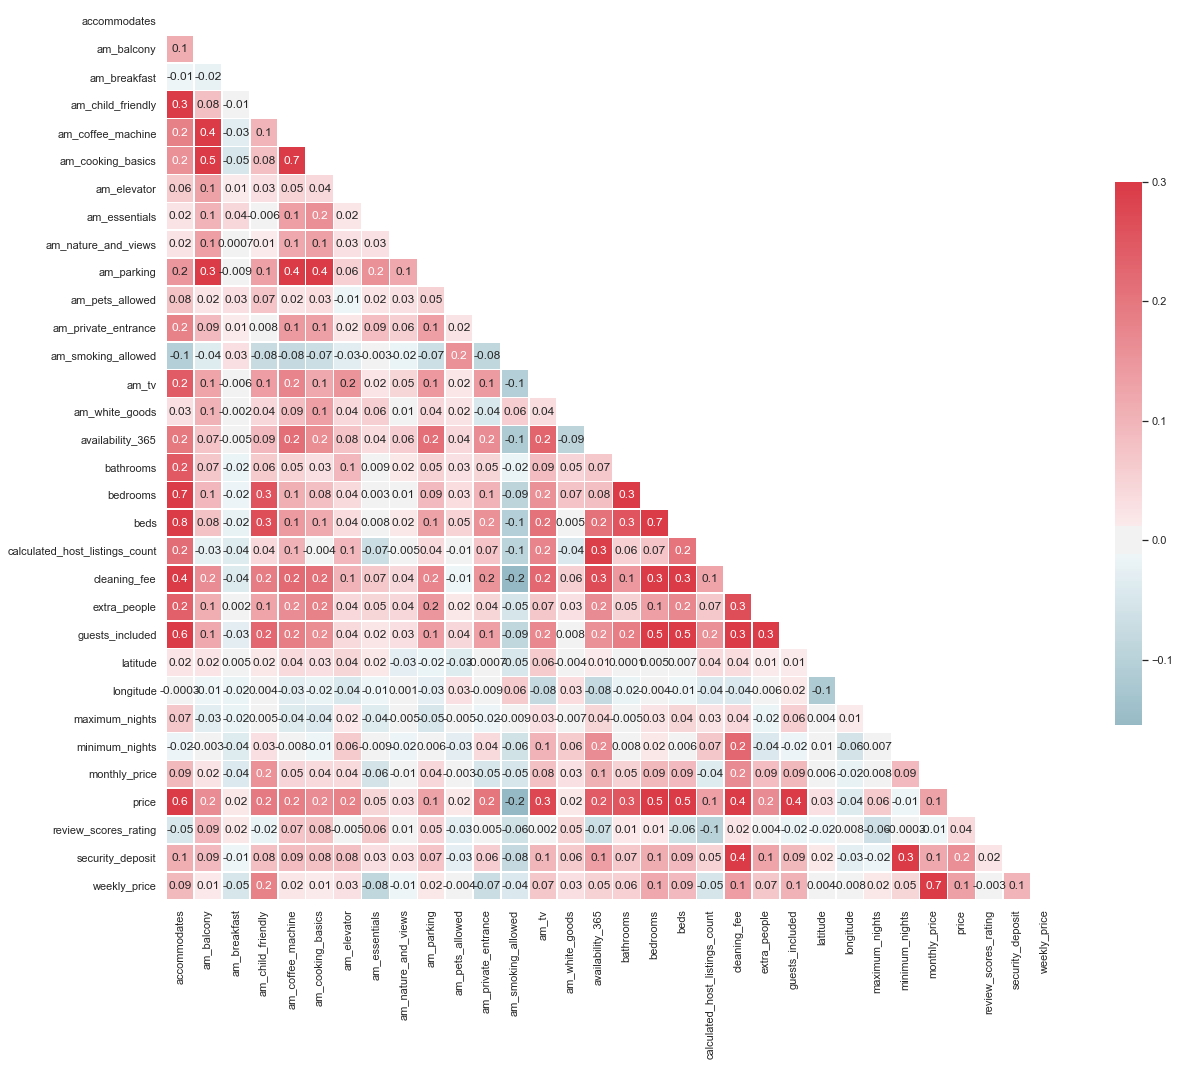

In [150]:
# Plot correlation heatmap for numerical features
#Generate a mask for the upper triangle
mask = np.triu(np.ones_like(data[num_features].corr(), dtype=np.bool))

#Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

#Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

#Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(data[num_features].corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".1g");

plt.savefig("data/figures/fig1_heatmap.png")

Highly correlated features will be removed from the analysis. For this purpose, the threshold is set at two correlations of 0.4 or above. Hence, the following features are removed:

| **FEATURE** | **REASONING** |
| :----- | :----- |
| **am_cooking_basics** | Particularly high correlation with **am_coffee_machine** and **am_balcony** |
| **bedroom** and **beds** | High correlation with each other, with **accommodates** and similar correlation with other features: Combine the two features to one (bed_proxy) |
| **guests_included** | High correlation with many features |
| **security_deposit** and **space** | Similar correlation to **cleaning_fee** or **extra_people**: Potentially make a numerical feature counting amount of "special" features instead (0-4) |
| **** |  |



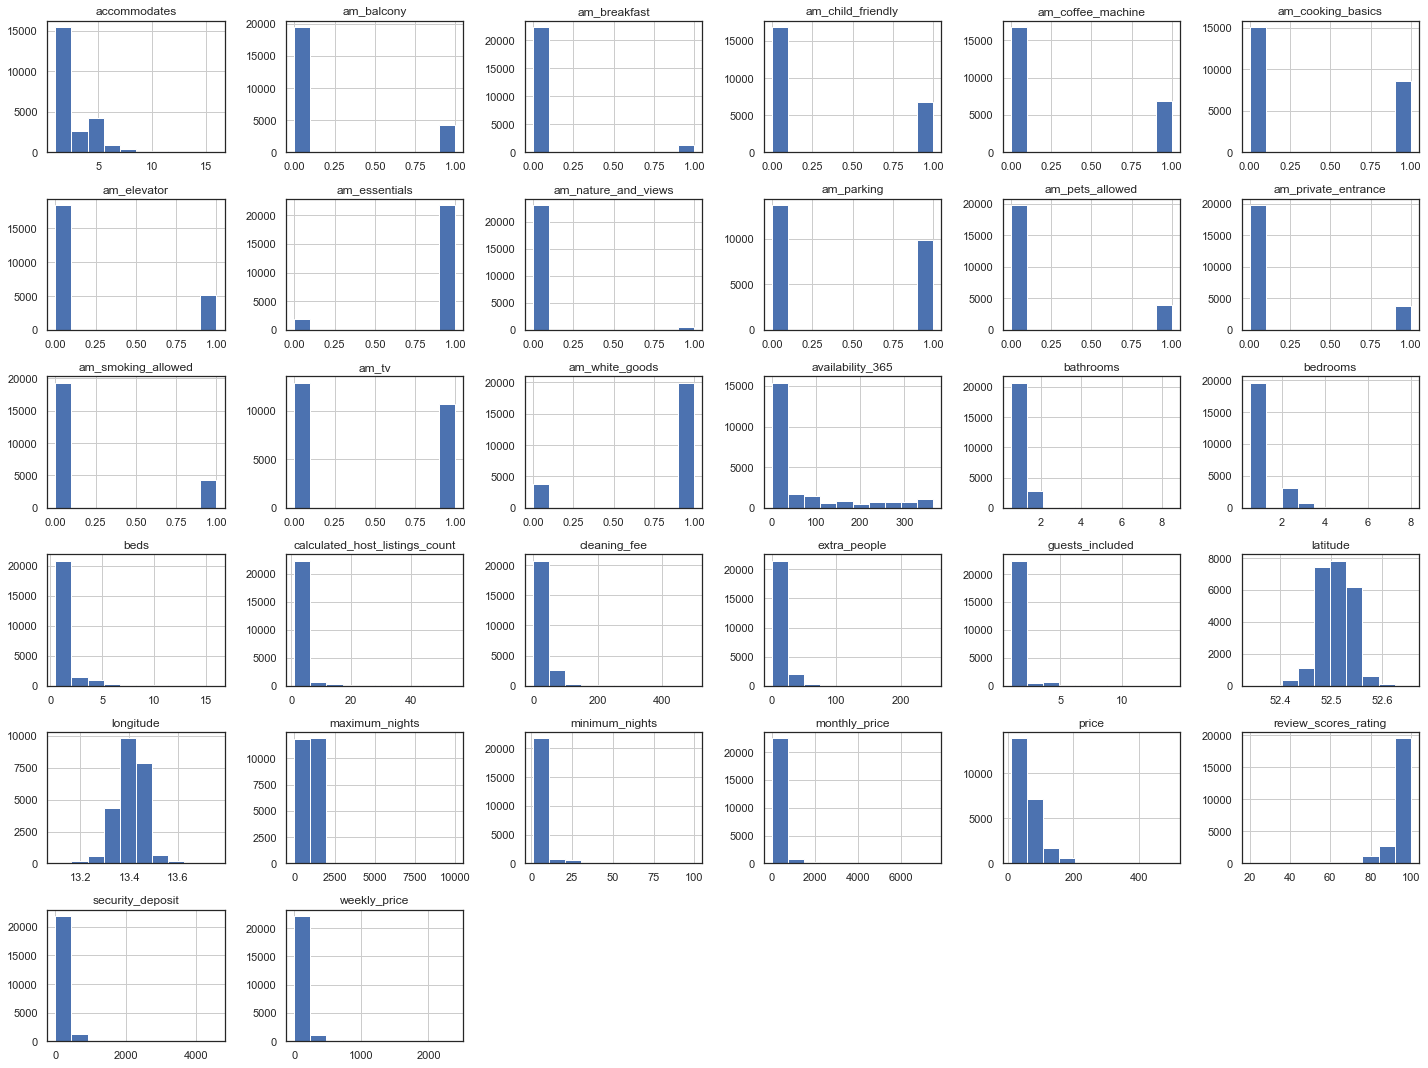

In [151]:
# Plot histogram of numerical features
data[num_features].hist(figsize=(20,15));
plt.tight_layout()

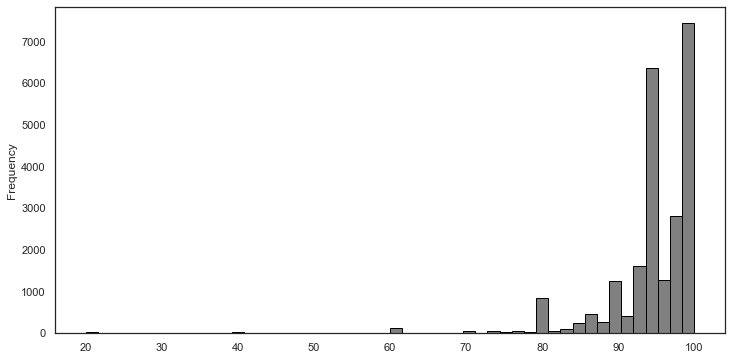

In [152]:
# Plot histogram of skewed feature
data.review_scores_rating.plot(kind='hist', bins=50, figsize=(12,6), facecolor='grey',edgecolor='black');
plt.savefig("data/figures/fig2_histogram_review_scores.png")

In [153]:
fig = go.Figure(data=go.Bar(y=[2, 3, 1]))
fig.show()

## Map visualizations (graphical exploration)

In [154]:
# Display contents of neighbourhoods.geojson visually

# Load up the file
data_2019_12_11_neighb_geojson = gpd.read_file('data/2019-12-11/neighbourhoods.geojson')

# Dropping the redundant column
data_2019_12_11_neighb_geojson.drop('neighbourhood_group', axis=1, inplace=True)

# Creating a dataframe of listing counts and median price by borough
neighbourhood_df = pd.DataFrame(data.groupby('neighbourhood').size())
neighbourhood_df.rename(columns={0: 'number_of_listings'}, inplace=True)
neighbourhood_df['median_price'] = data.groupby('neighbourhood').price.median().values

# Joining the dataframes
neighbourhood_map_df = data_2019_12_11_neighb_geojson.set_index('neighbourhood').join(neighbourhood_df)

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning:

invalid value encountered in less



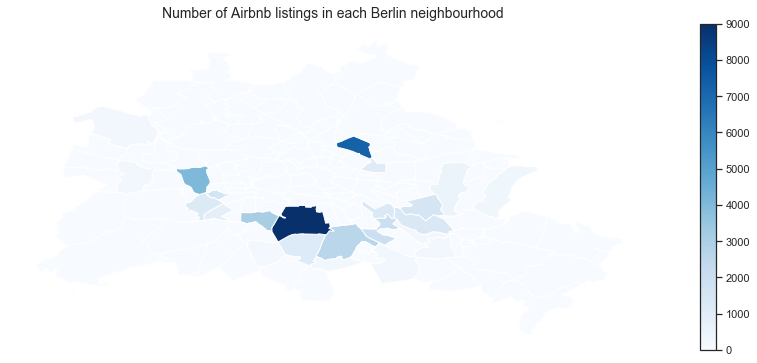

In [155]:
# Plotting the number of listings in each borough
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
neighbourhood_map_df.plot(column='number_of_listings', cmap='Blues', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each Berlin neighbourhood', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.savefig("data/figures/fig3_map_listings_neighbourhood.png")

/opt/anaconda3/envs/nf/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning:

invalid value encountered in less



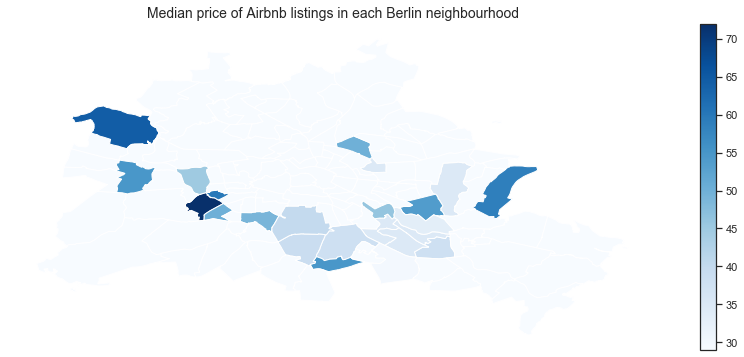

In [156]:
# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
neighbourhood_map_df.plot(column='median_price', cmap='Blues', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each Berlin neighbourhood', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(neighbourhood_map_df.median_price), vmax=max(neighbourhood_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.savefig("data/figures/fig4_map_median_price_neighbourhood.png")